# Inciso 3

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from typing import Callable, Dict, Any

def gradient_descent(
    f: Callable,
    df: Callable,
    dff: Callable,
    x0: np.ndarray,
    alpha: float = 0.1,
    max_iter: int = 1000,
    epsilon: float = 1e-6,
) -> Dict[str, Any]:

    x = x0.copy()
    x_sequence = [x.copy()]
    f_sequence = [f(x)]
    errors = []

    for k in range(max_iter):
        grad = df(x)
        error = np.linalg.norm(grad)
        errors.append(error)

        if error < epsilon:
            converged = True
            break

        # Move along negative gradient
        x = x - alpha * grad

        x_sequence.append(x.copy())
        f_sequence.append(f(x))

    else:
        converged = False

    return {
        "best": x,
        "x_sequence": x_sequence,
        "f_sequence": f_sequence,
        "errors": errors,
        "iterations": len(errors),
        "converged": converged,
    }

In [157]:
peaks = [
    {"x0": 1, "y0": 1, "sigma": 0.5},
    {"x0": 3, "y0": 3, "sigma": 0.5},
    {"x0": 2, "y0": 5, "sigma": 0.5},
    {"x0": 2, "y0": 5, "sigma": 0.5},
    {"x0": 7, "y0": 7, "sigma": 0.5},
    {"x0": 2.1, "y0": 6.6, "sigma": 0.5},
    {"x0": 6, "y0": 3, "sigma": 0.5},
    {"x0": 3.1, "y0": 1.5, "sigma": 0.5},
    {"x0": 7.5, "y0": 1.2, "sigma": 0.5},
]

In [154]:
def gaussian_2d(x, y, x0, y0, sigma=1):
    dx, dy = x - x0, y - y0
    return np.exp(-0.5 * (dx**2 + dy**2) / sigma**2)

def gaussian_sum_2d(point):
    """Inverse (negative) sum of multiple 2D Gaussians. point = [x,y]."""
    x, y = point
    return -sum(gaussian_2d(x, y, **p) for p in peaks)

def grad_gaussian_2d(point):
    x, y = point
    grad = np.zeros(2)
    for p in peaks:
        dx, dy = x - p["x0"], y - p["y0"]
        g = gaussian_2d(x, y, p["x0"], p["y0"], p["sigma"])
        grad[0] +=  dx / p["sigma"]**2 * g
        grad[1] +=  dy / p["sigma"]**2 * g
    return grad

def hess_gaussian_2d(point):
    x, y = point
    H = np.zeros((2, 2))
    for p in peaks:
        x0 = p["x0"]
        y0 = p["y0"]
        sigma = p["sigma"]
        dx, dy = x - x0, y - y0
        g = gaussian_2d(x, y, x0, y0, sigma)
        
        H[0,0] += g * ((dx**2 / sigma**4) - (1 / sigma**2))
        H[1,1] += g * ((dy**2 / sigma**4) - (1 / sigma**2))
        H[0,1] += g * (dx * dy / sigma**4)
        H[1,0] = H[0,1]
    
    return H

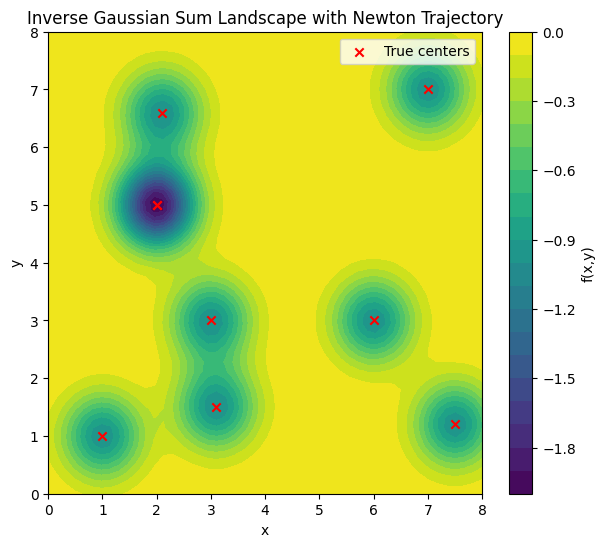

In [158]:
def plot_inv_gaussian(peaks, resolution=200, trajectory=None):
    x = np.linspace(0, 8, resolution)
    y = np.linspace(0, 8, resolution)
    X, Y = np.meshgrid(x, y)

    Z = np.zeros_like(X)
    for i in range(resolution):
        for j in range(resolution):
            Z[i, j] = gaussian_sum_2d((X[i, j], Y[i, j]))

    plt.figure(figsize=(7, 6))
    cp = plt.contourf(X, Y, Z, levels=20, cmap="viridis")
    plt.colorbar(cp, label="f(x,y)")

    # Plot true Gaussian centers
    plt.scatter([p["x0"] for p in peaks], [p["y0"] for p in peaks],
                c="red", marker="x", label="True centers")

    # Plot trajectory if provided
    if trajectory is not None:
        traj = np.array(trajectory)
        plt.plot(traj[:, 0], traj[:, 1], marker="o", c="red", lw=1, label="Newton path")
        plt.scatter(traj[-1, 0], traj[-1, 1], c="yellow", s=100, edgecolors="black", label="Converged minimum")

    plt.title("Inverse Gaussian Sum Landscape with Newton Trajectory")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

plot_inv_gaussian(peaks, resolution=50)

Converged: True
Minimum found at: [6.00003068 2.99999022]
Function value: -1.0000170571354485


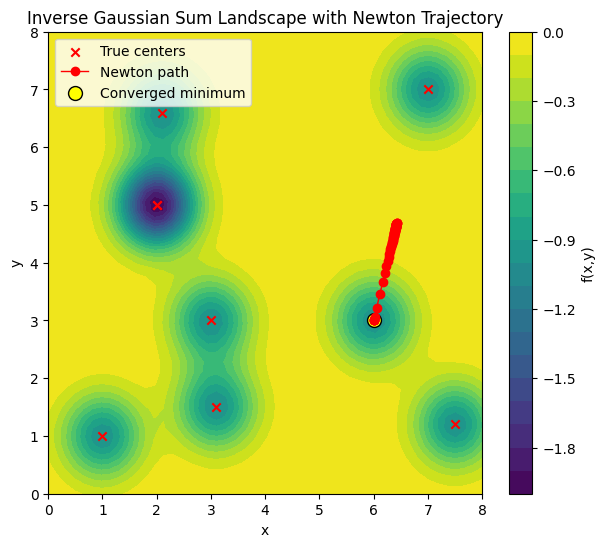

Converged: True
Minimum found at: [7.49996342 1.20001834]
Function value: -1.000017041738919


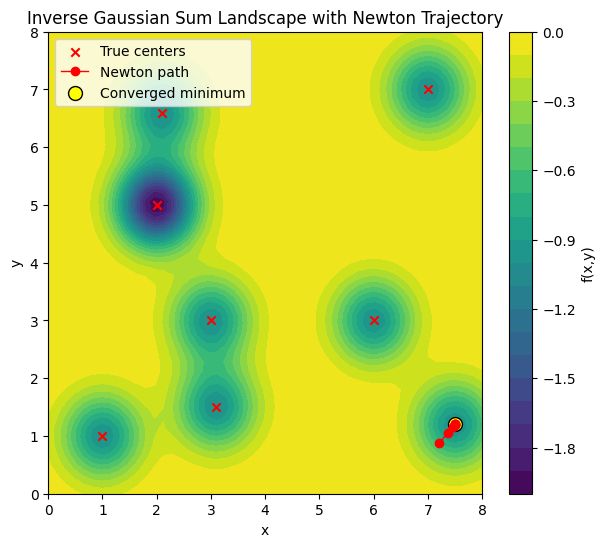

Converged: True
Minimum found at: [2.09867454 6.57882631]
Function value: -1.0125108230263544


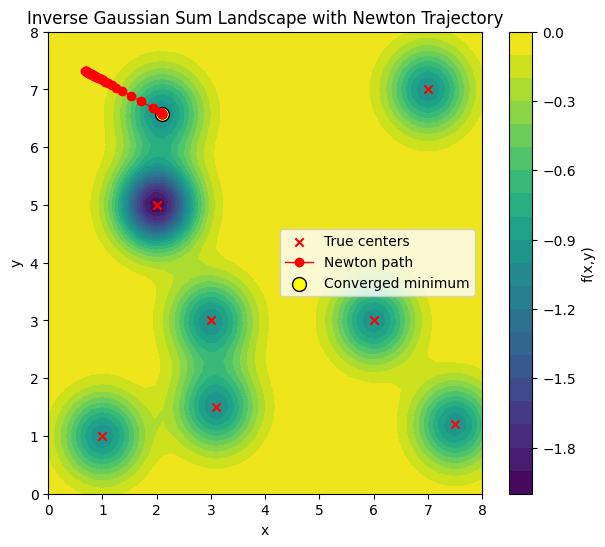

Converged: True
Minimum found at: [1.00018497 1.0000396 ]
Function value: -1.0000898015317534


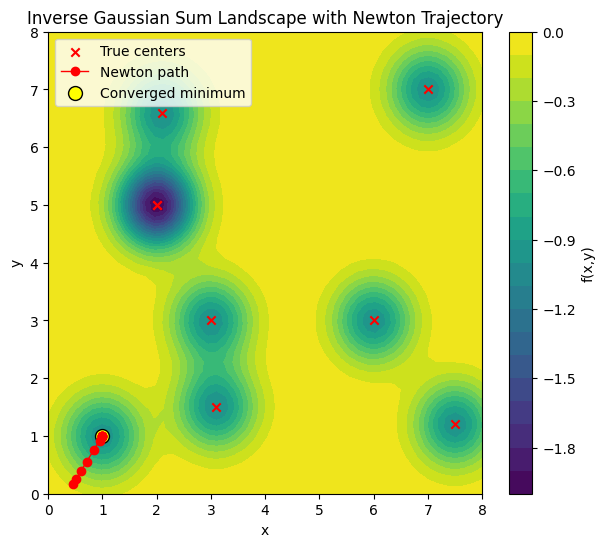

Converged: True
Minimum found at: [3.00112502 2.98221527]
Function value: -1.011556566948768


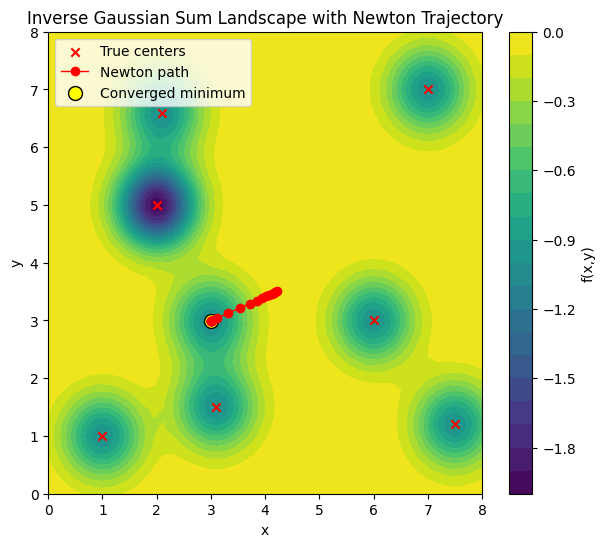

Converged: True
Minimum found at: [2.00033334 5.00477409]
Function value: -2.005992102430907


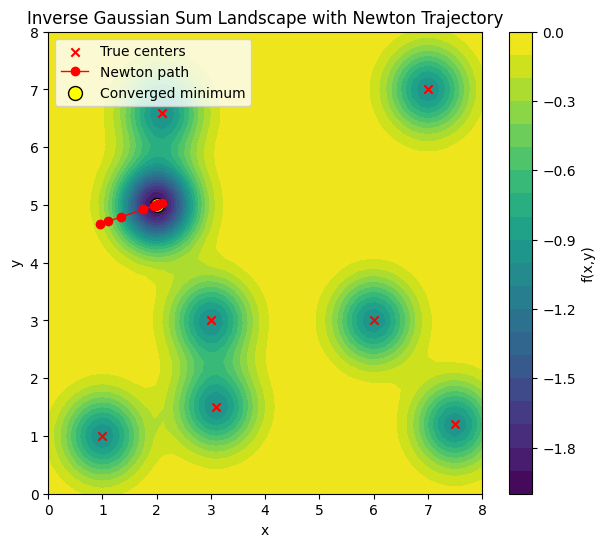

Converged: True
Minimum found at: [3.09863094 1.51792421]
Function value: -1.0115654886191991


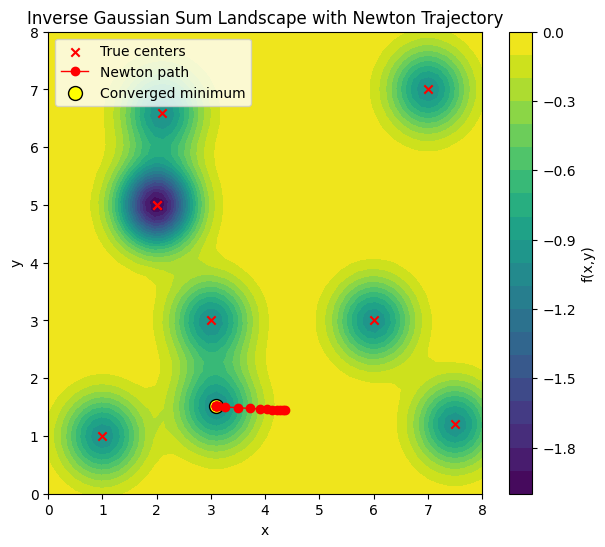

Converged: True
Minimum found at: [6.99998497 6.99999901]
Function value: -0.999999999546444


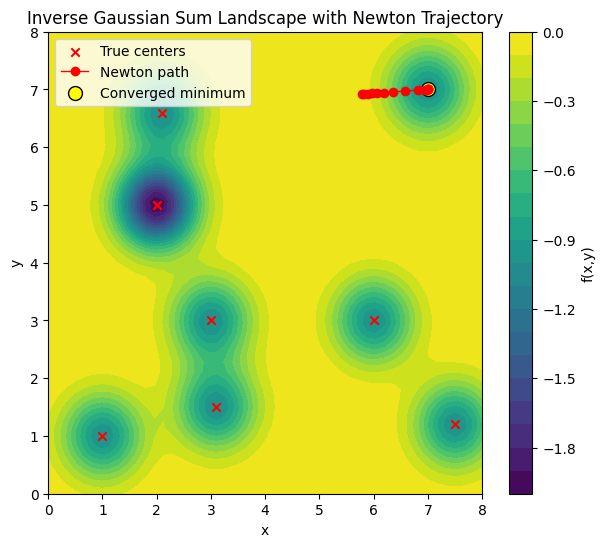

[array([6.00003068, 2.99999022]), array([7.49996342, 1.20001834]), array([2.09867454, 6.57882631]), array([1.00018497, 1.0000396 ]), array([3.00112502, 2.98221527]), array([2.00033334, 5.00477409]), array([3.09863094, 1.51792421]), array([6.99998497, 6.99999901])]


In [171]:
def already_found(pt, found_points, tol=1e-2):
    for p in found_points:
        if np.allclose(pt, p, atol=tol):
            return True
    return False

points_found = []

# Start point
while len(points_found) != len(peaks) - 1:
    x0 = np.random.uniform(0, 8, size=(2,))
    result = gradient_descent(
        gaussian_sum_2d, 
        grad_gaussian_2d, 
        hess_gaussian_2d, 
        x0, alpha=0.2, max_iter=500, epsilon=1e-4)
    
    if abs(gaussian_sum_2d(result["best"])) <= 1e-4:
        continue

    if not already_found(result["best"], points_found) and result["converged"]:
        print("Converged:", result["converged"])
        print("Minimum found at:", result["best"])
        print("Function value:", gaussian_sum_2d(result["best"]))
        points_found.append(result["best"])
        plot_inv_gaussian(peaks, resolution=50, trajectory=result["x_sequence"])

print(points_found)